<a href="https://colab.research.google.com/github/tyunist/Receptive-Field-in-Pytorch/blob/master/Receptive_Field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Receptive Field
If you have worked a little or you are somewhat familiar with Convolutional Network, you probably have heard about the term receptive field (RF). 
It is defined as the window size of input voxels that affects one particular output voxel. This hyperparameter is important since it indicates the context size that the network is using in order to compute one particular output voxel. 
There are some posts that explain more in detail about it, and how to compute it analitycally for simple architectures like AlexNet. Look [here](https://medium.com/@nikasa1889/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807) for example.

To make it more clear I think is better to use a 1D image:

<img src="https://github.com/tyunist/Receptive-Field-in-Pytorch/blob/master/RF1.png?raw=1" width="600" height="600" />

In this image, I show an input with say 12 positions, and I will apply 2 convolutional layers (1D in this case).
for each layer we need to define a size and a stride. Here I used a kernel size $F=3$ and a stride $s=1$.
We can see that every position in the first output depends on 3 input positions.
Now if we apply the second convolution, each position in the final output depends on 5 input positions!
You can imgine that adding more layers the RF will keep increasing. 
How can we compute it?
Well, as explained in the linked post, it is easy to compute by finding the necessary input size that produces an output of exactly one voxel. This can be computed by a recursive program which starts at the last layer by setting the output size to one and finding the necessary input size. This size will be used for the previous layer as the desired output and we keep going until the first layer. For a given convolutional (and pooling layer) we have

\begin{equation}
O_{sz}=\frac{I_{sz}-F}{s}+1
\end{equation}

where $O_{sz}$ and $I_{sz}$ refer to the output and input sizes, $F$ is the filter (or kernel) size and $s$ is the stride. 
If we want to compute the RF we first set $O_{sz}=1$ and find the corresponding $I_{sz}$. In this case we would find $I_{sz}=3$. That is the RF of the last layer. Now if we keep going for the additional first layer, now setting $O_{sz}=3$ (the value we just found), we get $I_{sz}=5$.
This is the RF of the network of the figure!

We can build a simple script to compute this value

.



In [2]:
def compute_N(out,f,s):
    return s*(out-1)+f if s>0.5 else ((out+(f-2))/2)+1#

def compute_RF(layers):
    out=1
    for f,s in reversed(layers):
        out=compute_N(out,f,s)
    return out

Here we just pass a list of tuples ($F$,$s$)
For example 

In [4]:
layers=[(9,1),(3,1),(3,1),(3,1),(9,1),(3,1),(3,1),(7,1),(3,1)]
compute_RF(layers)

35

For that network we find that the RF is 35.


But what if the network is very complicated, and it does not have a structred architecture?
It can be really tedious to do it analitycally and sometimes just not possible.
Turns out there is another way to compute this value numerically.
In particular, we can use only one output channel in the last layer which we call $f=[f_1,\dots,f_N]$. Now if we define a dummy loss function $l$ and we set its gradient with respect to $f ~\nabla_f l$  to be zero everywhere except in a particular location $j$ which for convenience we set to 1:
\begin{equation}
\frac{\partial l}{\partial f_i}=
\begin{cases}
    0,& \forall i \neq j\\
    1,              & \text{otherwise}
\end{cases}
\end{equation}

If we perform backpropagation until the input $x=[x1,\dots,x_N]$ which is equivalent to compute $\nabla_x l$ using the chain rule, we would find that $\frac{\partial l}{\partial x_i}\neq 0$ only if $x_i$ has some effect in $f_j$ which in turn, equals to find the RF. To be more precise, we chose the position $j$ to be in the center of the image, we set the weights of the network to be a positive constant (one in our case), and the biases to zero. This is because we use ReLUs as activation functions which would set to zero any negative value. In addition, the Max-Pooling layers are changed to Average-Pooling in order to avoid sparsity in the gradients. 

I will show an implementation using PyTorch.
Fisrt I implement the same CNN that I defined through the layers list. The code is fairly simple:


In [7]:
import numpy as np
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.init as init
import torch.nn.functional as F

def compute_RF_numerical(net,img_np):
    '''
    @param net: Pytorch network
    @param img_np: numpy array to use as input to the networks, it must be full of ones and with the correct
    shape.
    '''
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.fill_(1)
            m.bias.data.fill_(0)
    net.apply(weights_init)
    img_ = Variable(torch.from_numpy(img_np).float(),requires_grad=True)
    out_cnn=net(img_)
    out_shape=out_cnn.size()
    ndims=len(out_cnn.size())
    grad=torch.zeros(out_cnn.size())
    l_tmp=[]
    for i in xrange(ndims):
        if i==0 or i ==1:#batch or channel
            l_tmp.append(0)
        else:
            l_tmp.append(out_shape[i]/2)
            
    grad[tuple(l_tmp)]=1
    out_cnn.backward(gradient=grad)
    grad_np=img_.grad[0,0].data.numpy()
    idx_nonzeros=np.where(grad_np!=0)
    RF=[np.max(idx)-np.min(idx)+1 for idx in idx_nonzeros]
    
    return RF, grad_np

class CNN(nn.Module):
    def __init__(self,layer_list):
        #layers is a list of tuples [(f,s)]
        super(CNN, self).__init__()
        f_ini,s_ini=layer_list[0]
        f_end,s_end=layer_list[-1]
        self.layers=[]
        self.layers.append(nn.Conv2d(1, 16, kernel_size=f_ini, padding=1,stride=s_ini,dilation=1))
        for f,s in layer_list[1:-1]:
            self.layers.append(nn.Conv2d(16, 16, kernel_size=f, padding=1,stride=s,dilation=1))
            self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.Conv2d(16, 1, kernel_size=f_end, padding=1,stride=s_end,dilation=1))
        self.all_layers=nn.Sequential(*self.layers)
        
        
    def forward(self, x):
        out = self.all_layers(x)
        return out

###########################################################
print 'analytical RF:',compute_RF(layers)

mycnn=CNN(layers)


img_np=np.ones((1,1,100,100))
RF, grad_img = compute_RF_numerical(mycnn,img_np)
print('numerical RF: ', RF)

analytical RF: 35
('numerical RF: ', [35, 35])


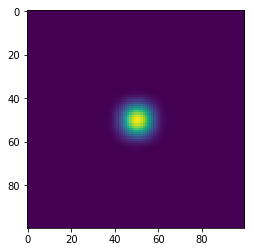

In [8]:
import matplotlib.pyplot as plt
plt.imshow(grad_img)
plt.show()

We can see that both methods find the same RF value.
You just need to be careful when computing the RF by initializing the parameters, changing max pool layers by average pooling and switch off batchnorm and dropout. This method is general and will work even for very complicated networks. 